# Similarity Encoders with Keras
## using the model definition from `simec.py`

In [1]:
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

import tensorflow as tf
tf.set_random_seed(28)
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation

# https://github.com/cod3licious/nlputils
from nlputils.features import FeatureTransform, features2mat

from simec import SimilarityEncoder
from utils import center_K, check_embed_match, check_similarity_match
from utils_plotting import plot_mnist, plot_20news

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### MNIST with Linear Kernel

In [2]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 10000 random data points
np.random.seed(42)
n_samples = 10000
n_test = 2000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
X_test = ss.transform(X_test)
n_train, n_features = X.shape

In [3]:
# centered linear kernel matrix
K_lin = center_K(np.dot(X, X.T))

error similarity match: msqe: 51.4531662441 ; r^2: 0.4438507851 ; rho: 0.6341602248


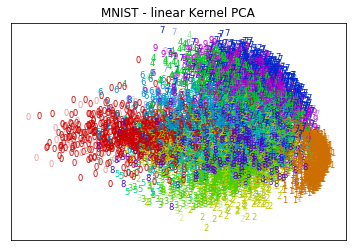

In [4]:
# linear kPCA
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - linear Kernel PCA')
print "error similarity match: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_lin)

Epoch 1/25
8000/8000 [==============================] - 1s 155us/step - loss: 138.9871
Epoch 2/25
8000/8000 [==============================] - 1s 93us/step - loss: 134.7487
Epoch 3/25
8000/8000 [==============================] - 1s 88us/step - loss: 128.0694
Epoch 4/25
8000/8000 [==============================] - 1s 93us/step - loss: 121.4029
Epoch 5/25
8000/8000 [==============================] - 1s 93us/step - loss: 116.2597
Epoch 6/25
8000/8000 [==============================] - 1s 95us/step - loss: 112.6398
Epoch 7/25
8000/8000 [==============================] - 1s 93us/step - loss: 109.3631
Epoch 8/25
8000/8000 [==============================] - 1s 87us/step - loss: 105.8619
Epoch 9/25
8000/8000 [==============================] - 1s 89us/step - loss: 102.6419
Epoch 10/25
8000/8000 [==============================] - 1s 94us/step - loss: 100.4048
Epoch 11/25
8000/8000 [==============================] - 1s 92us/step - loss: 99.2771
Epoch 12/25
8000/8000 [=============================

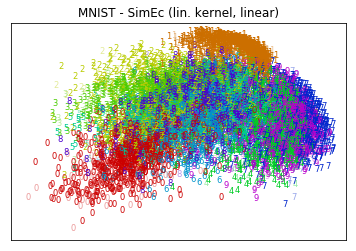

In [5]:
# on how many target similarities you want to train - faster and works equally well than training on all
n_targets = 1000  # K_lin.shape[1]
# initialize the model
simec = SimilarityEncoder(X.shape[1], 2, n_targets, s_ll_reg=0.5, S_ll=K_lin[:n_targets,:n_targets])
# train the model to get an embedding with which the target similarities
# can be linearly approximated
simec.fit(X, K_lin[:,:n_targets], epochs=25)
# get the embeddings
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (lin. kernel, linear)')
# correlation with the embedding produced by the spectral method should be high
print "correlation with lin kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with lin kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
# similarity match error should be similar to the one from kpca
print "error similarity match: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin)

### Non-linear MNIST embedding with isomap

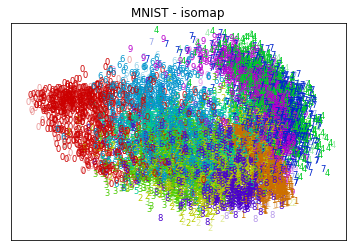

In [6]:
# isomap
isomap = Isomap(n_neighbors=10, n_components=2)
X_embed = isomap.fit_transform(X)
X_embed_test = isomap.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - isomap')

Epoch 1/25
8000/8000 [==============================] - 1s 129us/step - loss: 49.0714
Epoch 2/25
8000/8000 [==============================] - 1s 115us/step - loss: 45.4046
Epoch 3/25
8000/8000 [==============================] - 1s 104us/step - loss: 45.0915
Epoch 4/25
8000/8000 [==============================] - 1s 110us/step - loss: 44.9133
Epoch 5/25
8000/8000 [==============================] - 1s 112us/step - loss: 44.7959
Epoch 6/25
8000/8000 [==============================] - 1s 107us/step - loss: 44.7033
Epoch 7/25
8000/8000 [==============================] - 1s 112us/step - loss: 44.6246
Epoch 8/25
8000/8000 [==============================] - 1s 108us/step - loss: 44.5676
Epoch 9/25
8000/8000 [==============================] - 1s 108us/step - loss: 44.5193
Epoch 10/25
8000/8000 [==============================] - 1s 106us/step - loss: 44.4928
Epoch 11/25
8000/8000 [==============================] - 1s 108us/step - loss: 44.4598
Epoch 12/25
8000/8000 [=============================

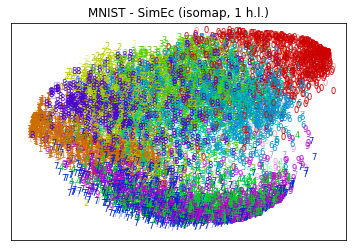

In [7]:
# non-linear SimEc to approximate isomap solution
K_geod = center_K(isomap.dist_matrix_)
n_targets = 1000
# initialize the model
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(20, 'tanh')], s_ll_reg=0.5, S_ll=K_geod[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.01))
# train the model to get an embedding with which the target similarities
# can be linearly approximated
simec.fit(X, K_geod[:,:n_targets], epochs=25)
# get the embeddings
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (isomap, 1 h.l.)')
print "correlation with isomap       : %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with isomap (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]

## 20newsgroups embedding

In [8]:
## load the data and transform it into a tf-idf representation
categories = [
    "comp.graphics",
    "rec.autos",
    "rec.sport.baseball",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns"
]
newsgroups_train = fetch_20newsgroups(subset='train', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
# store in dicts (if the text contains more than 3 words)
textdict = {i: t for i, t in enumerate(newsgroups_train.data) if len(t.split()) > 3}
textdict.update({i: t for i, t in enumerate(newsgroups_test.data, len(newsgroups_train.data)) if len(t.split()) > 3})
train_ids = [i for i in range(len(newsgroups_train.data)) if i in textdict]
test_ids = [i for i in range(len(newsgroups_train.data), len(textdict)) if i in textdict]
print "%i training and %i test samples" % (len(train_ids), len(test_ids))
# transform into tf-idf features
ft = FeatureTransform(norm='max', weight=True, renorm='max')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# organize in feature matrix
X, featurenames = features2mat(docfeats, train_ids)
X_test, _ = features2mat(docfeats, test_ids, featurenames)
print "%i features" % len(featurenames)
targets = np.hstack([newsgroups_train.target,newsgroups_test.target])
y = targets[train_ids]
y_test = targets[test_ids]
target_names = newsgroups_train.target_names
n_targets = 1000

3959 training and 2359 test samples
45813 features


similarity approximation       : msqe: 0.0331868908 ; r^2: 0.2263374840 ; rho: 0.6310964767
similarity approximation (test): msqe: 0.0421617582 ; r^2: 0.1775899837 ; rho: 0.6165146584


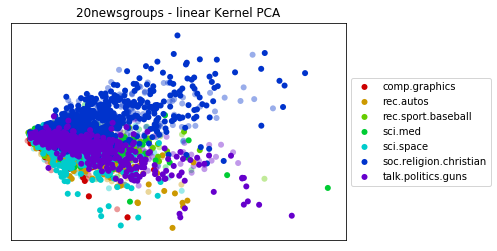

In [9]:
# linear kPCA
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_20news(X_embed, y, target_names, X_embed_test, y_test,
            title='20newsgroups - linear Kernel PCA', legend=True)
# compute linear kernel and center
K_lin = center_K(X.dot(X.T).A)
K_lin_test = center_K(X_test.dot(X_test.T).A)
print "similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_lin)
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_test, K_lin_test)

Epoch 1/25
3959/3959 [==============================] - 1s 140us/step - loss: 0.0366
Epoch 2/25
3959/3959 [==============================] - 0s 104us/step - loss: 0.0318
Epoch 3/25
3959/3959 [==============================] - 0s 102us/step - loss: 0.0315
Epoch 4/25
3959/3959 [==============================] - 0s 104us/step - loss: 0.0311
Epoch 5/25
3959/3959 [==============================] - 0s 110us/step - loss: 0.0311
Epoch 6/25
3959/3959 [==============================] - 0s 109us/step - loss: 0.0311
Epoch 7/25
3959/3959 [==============================] - 0s 103us/step - loss: 0.0310
Epoch 8/25
3959/3959 [==============================] - 0s 106us/step - loss: 0.0311
Epoch 9/25
3959/3959 [==============================] - 0s 101us/step - loss: 0.0310
Epoch 10/25
3959/3959 [==============================] - 0s 106us/step - loss: 0.0310
Epoch 11/25
3959/3959 [==============================] - 0s 102us/step - loss: 0.0310
Epoch 12/25
3959/3959 [==============================] - 0s 111

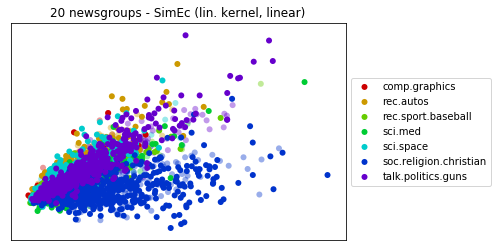

In [10]:
# project to 2d with linear similarity encoder
# careful: our input is sparse!!!
simec = SimilarityEncoder(X.shape[1], 2, n_targets, sparse_inputs=True, opt=keras.optimizers.SGD(lr=50.))
# train the model to get an embedding with which the target similarities
# can be linearly approximated
simec.fit(X, K_lin[:,:n_targets], epochs=25)
# get the embeddings
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_20news(X_embeds, y, target_names, X_embed_tests, y_test,
            title='20 newsgroups - SimEc (lin. kernel, linear)', legend=True)
print "correlation with lin kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1]
print "correlation with lin kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1]
print "similarity approximation       : msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin)
print "similarity approximation (test): msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed_tests, K_lin_test)